In [4]:
# optimal_2d_bin_packing.py
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
# ================== PROBLEMA ==================

Rectangulos=pd.read_csv("Archivos_Ingreso/rectangulos.csv")
Rectangulos["Area"]=Rectangulos.apply(lambda x: x["Base"]*x["Altura"],axis=1)
Rectangulos["ID"]=np.arange(0,len(Rectangulos))
Rectangulos["ID"]=Rectangulos.apply(lambda x: "XY"+str(int(x["ID"])),axis=1)

Rectangulos["Base"]=Rectangulos.apply(lambda x: x["Base"] if x["Base"]<=52 else 51.98, axis=1)

# ejemplo_rectpack.py 38
from rectpack import newPacker

# Lista de rectángulos (w, h, id)

rectangles = [
]
Rectangulos[["Base","Altura"]]=Rectangulos[["Base","Altura"]]*10
Rectangulos[["Base","Altura"]]=Rectangulos[["Base","Altura"]].round(0)
Rectangulos["Base"]=Rectangulos.apply(lambda x: int(x["Base"]),axis=1)
Rectangulos["Altura"]=Rectangulos.apply(lambda x: int(x["Altura"]),axis=1)
rectangles=Rectangulos[["Base","Altura","ID"]].to_numpy()
print(rectangles)
bin_width = 520
bin_height = 420

allow_rotation = False


[[293 110 'XY0']
 [355 110 'XY1']
 [406 110 'XY2']
 [449 110 'XY3']
 [520 102 'XY4']
 [520 102 'XY5']
 [520 102 'XY6']
 [520 102 'XY7']
 [520 125 'XY8']
 [520 125 'XY9']
 [520 113 'XY10']
 [520 113 'XY11']
 [520 107 'XY12']
 [520 109 'XY13']
 [520 106 'XY14']
 [520 108 'XY15']
 [520 100 'XY16']
 [520 101 'XY17']
 [520 97 'XY18']
 [520 94 'XY19']
 [520 104 'XY20']
 [520 104 'XY21']
 [520 105 'XY22']
 [519 103 'XY23']
 [520 107 'XY24']
 [516 106 'XY25']
 [518 106 'XY26']
 [520 106 'XY27']
 [520 104 'XY28']
 [520 102 'XY29']
 [517 102 'XY30']
 [519 103 'XY31']
 [499 93 'XY32']
 [490 90 'XY33']
 [505 89 'XY34']
 [493 87 'XY35']
 [507 85 'XY36']
 [520 92 'XY37']
 [520 71 'XY38']
 [520 71 'XY39']
 [520 71 'XY40']
 [520 71 'XY41']
 [520 71 'XY42']
 [520 71 'XY43']
 [520 55 'XY44']
 [486 63 'XY45']
 [485 63 'XY46']
 [484 62 'XY47']
 [484 71 'XY48']
 [483 66 'XY49']
 [482 64 'XY50']
 [479 65 'XY51']
 [481 79 'XY52']
 [477 79 'XY53']
 [474 75 'XY54']
 [486 75 'XY55']
 [508 88 'XY56']
 [507 90 'X

In [5]:

# Número máximo de contenedores candidato (no infinito, usar un límite práctico)
max_bins = len(rectangles)
# ==============================================

model = cp_model.CpModel()
n = len(rectangles)
K = max_bins

# Variables
x = {}  # x[i,k] posición x de rectángulo i en contenedor k
y = {}  # y[i,k] posición y
b = {}  # b[i,k] si el rectángulo i está en contenedor k
w_var = {}  # ancho considerando rotación
h_var = {}  # alto considerando rotación
rot = {}

for i, (wi, hi, rid) in enumerate(rectangles):
    for k in range(K):
        x[i,k] = model.NewIntVar(0, bin_width, f"x_{i}_{k}")
        y[i,k] = model.NewIntVar(0, bin_height, f"y_{i}_{k}")
        b[i,k] = model.NewBoolVar(f"b_{i}_{k}")
    if allow_rotation:
        r = model.NewBoolVar(f"rot_{i}")
        rot[i] = r
        w_var[i] = model.NewIntVar(min(wi, hi), max(wi, hi), f"w_{i}")
        h_var[i] = model.NewIntVar(min(wi, hi), max(wi, hi), f"h_{i}")
        model.Add(w_var[i] == wi).OnlyEnforceIf(r.Not())
        model.Add(w_var[i] == hi).OnlyEnforceIf(r)
        model.Add(h_var[i] == hi).OnlyEnforceIf(r.Not())
        model.Add(h_var[i] == wi).OnlyEnforceIf(r)
    else:
        w_var[i] = wi
        h_var[i] = hi

# Cada rectángulo debe estar en exactamente un contenedor
for i in range(n):
    model.Add(sum(b[i,k] for k in range(K)) == 1)

# No solapamiento dentro de cada contenedor (corregido)
for k in range(K):
    rects_in_bin = []
    for i in range(n):
        if allow_rotation:
            xi = x[i,k]
            yi = y[i,k]
            wi_var = w_var[i]
            hi_var = h_var[i]
        else:
            xi = x[i,k]
            yi = y[i,k]
            wi_var = rectangles[i][0]
            hi_var = rectangles[i][1]

        # Crear variables para los extremos
        end_x_var = model.NewIntVar(0, bin_width, f"end_x_{i}_{k}")
        end_y_var = model.NewIntVar(0, bin_height, f"end_y_{i}_{k}")

        # Relacionar con xi + wi_var y yi + hi_var solo si el rectángulo está presente
        model.Add(end_x_var == xi + wi_var).OnlyEnforceIf(b[i,k])
        model.Add(end_y_var == yi + hi_var).OnlyEnforceIf(b[i,k])

        # Crear intervalos opcionales usando end_var
        interval_x = model.NewOptionalIntervalVar(xi, wi_var, end_x_var, b[i,k], f"ix_{i}_{k}")
        interval_y = model.NewOptionalIntervalVar(yi, hi_var, end_y_var, b[i,k], f"iy_{i}_{k}")

        rects_in_bin.append((interval_x, interval_y))

    if rects_in_bin:
        x_ints, y_ints = zip(*rects_in_bin)
        model.AddNoOverlap2D(x_ints, y_ints)


# Rectángulos dentro de límites del contenedor
for i in range(n):
    for k in range(K):
        if allow_rotation:
            model.Add(x[i,k] + w_var[i] <= bin_width).OnlyEnforceIf(b[i,k])
            model.Add(y[i,k] + h_var[i] <= bin_height).OnlyEnforceIf(b[i,k])
        else:
            model.Add(x[i,k] + rectangles[i][0] <= bin_width).OnlyEnforceIf(b[i,k])
            model.Add(y[i,k] + rectangles[i][1] <= bin_height).OnlyEnforceIf(b[i,k])

# Variable de si el contenedor k se usa
used = [model.NewBoolVar(f"used_{k}") for k in range(K)]
for k in range(K):
    for i in range(n):
        model.AddImplication(b[i,k], used[k])

# Objetivo: minimizar número de contenedores usados
model.Minimize(sum(used))

# ===== Solve =====
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 900.0
solver.parameters.num_search_workers = 18

status = solver.Solve(model)

Pexport=[]
Hy=0



Status: FEASIBLE
Contenedores usados: 14


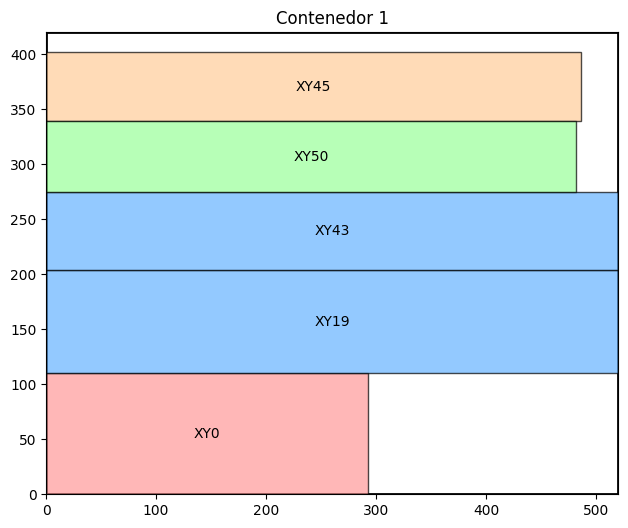

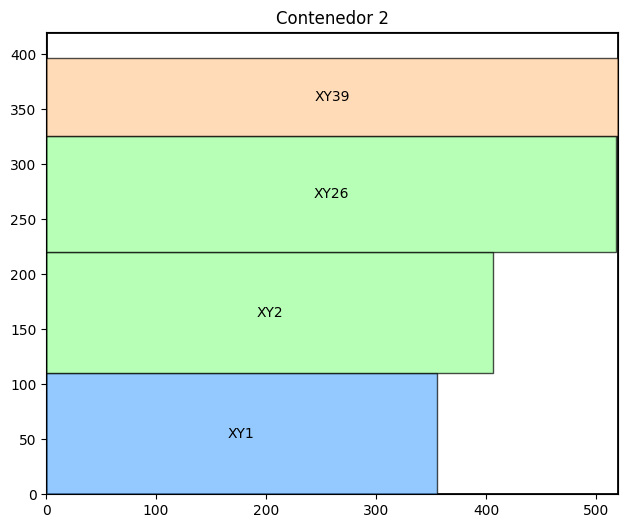

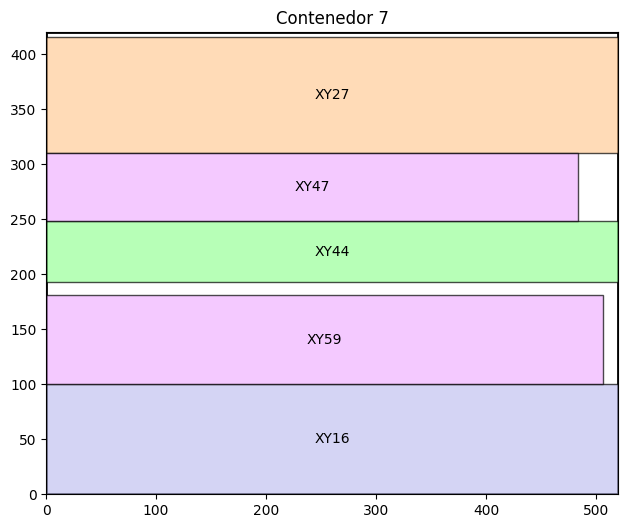

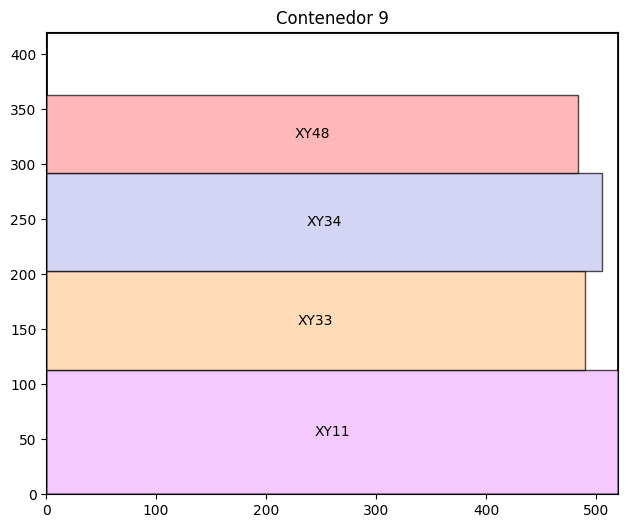

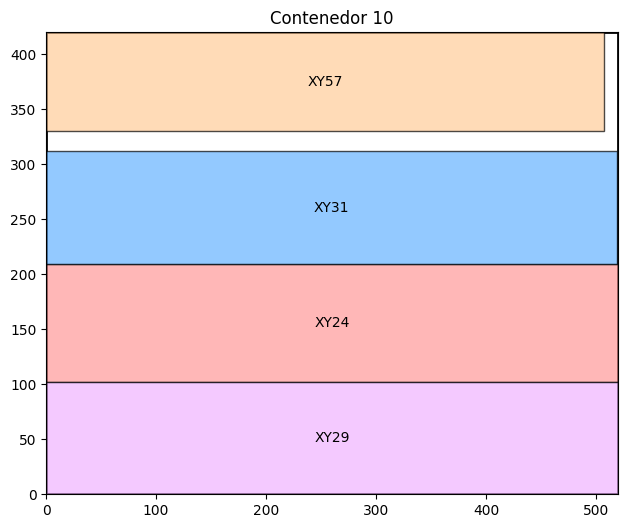

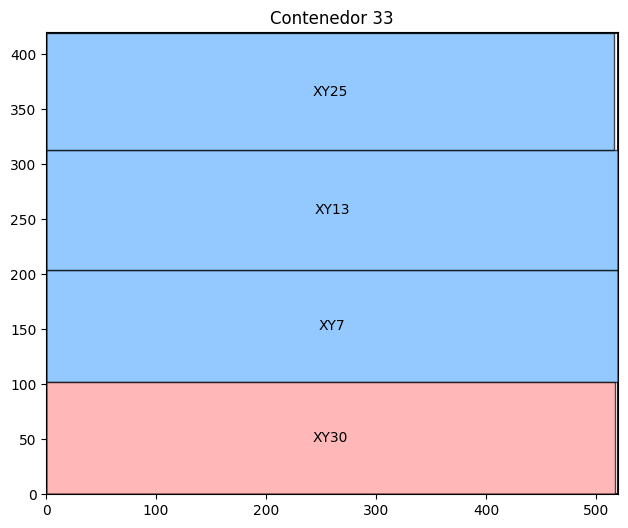

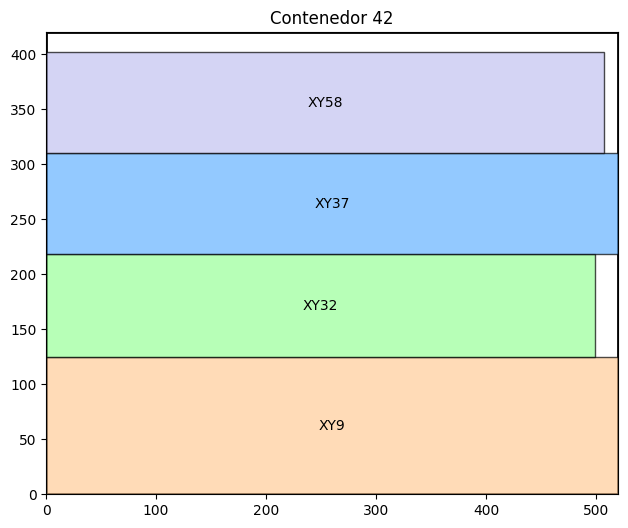

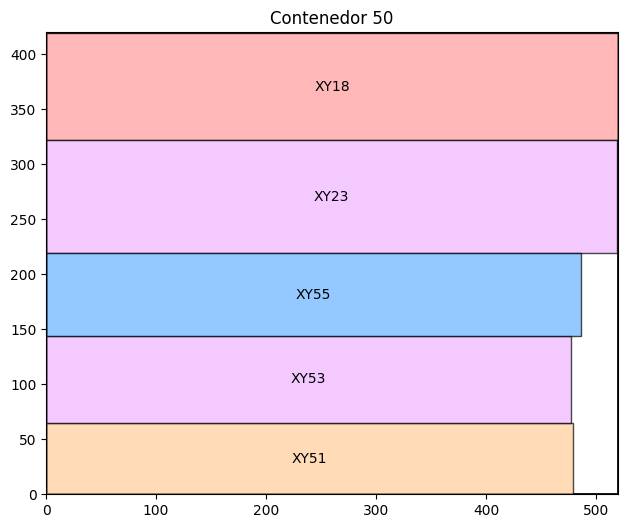

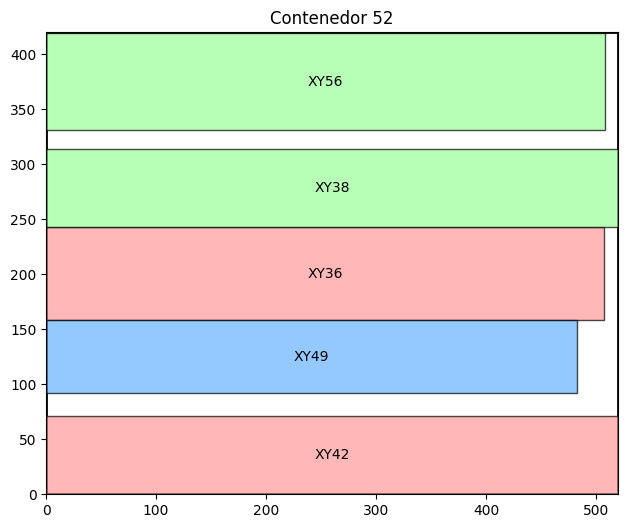

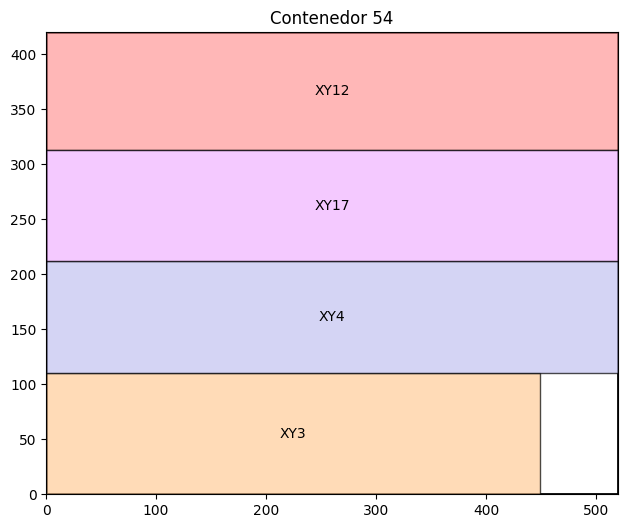

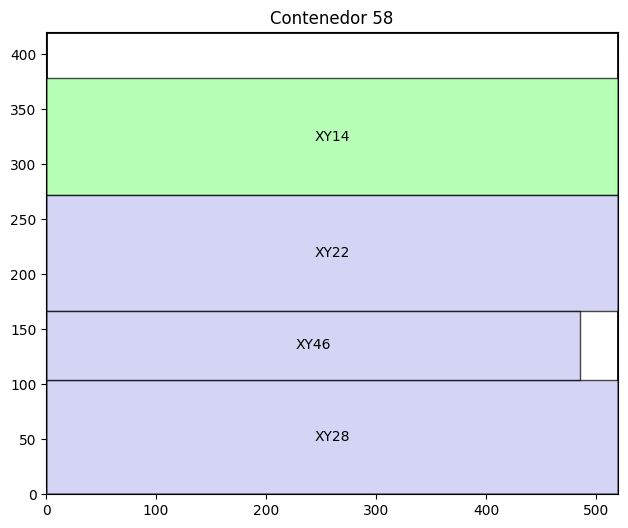

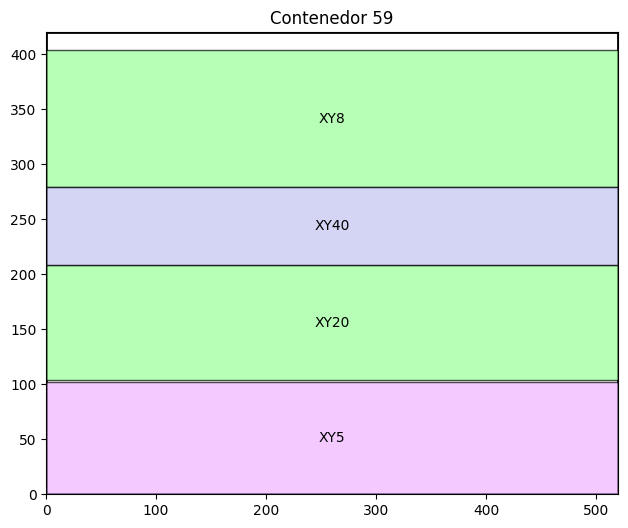

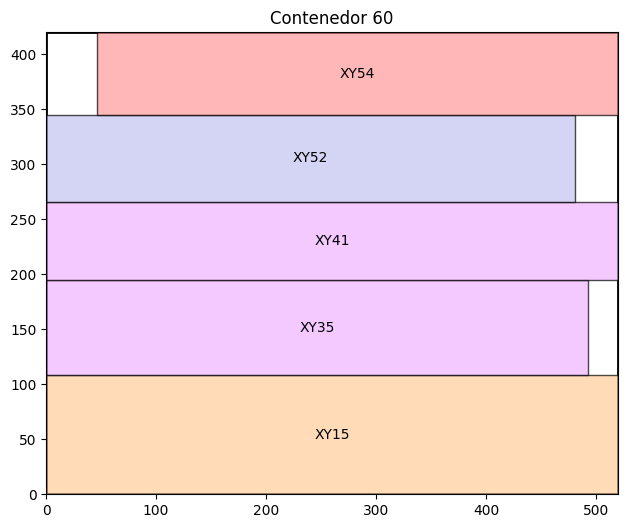

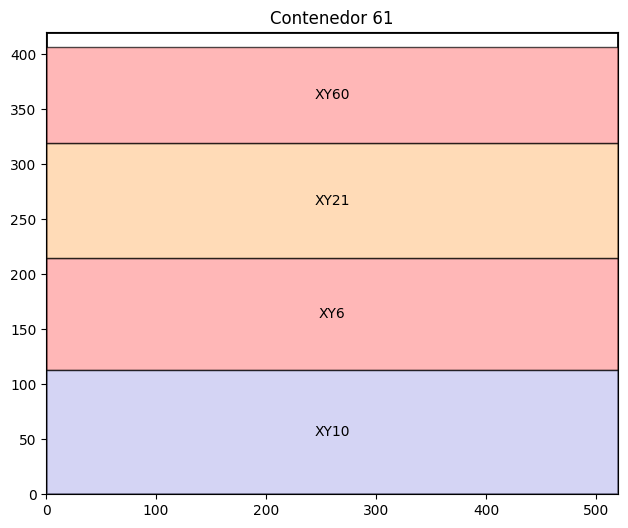

      ID    X      Y
0    XY0  0.0    0.0
1   XY19  0.0   11.0
2   XY43  0.0   20.4
3   XY45  0.0   33.9
4   XY50  0.0   27.5
..   ...  ...    ...
56  XY54  4.6  538.5
57   XY6  0.0  557.3
58  XY10  0.0  546.0
59  XY21  0.0  567.5
60  XY60  0.0  577.9

[61 rows x 3 columns]
      ID    X      Y
0    XY0  0.0    0.0
5    XY1  0.0   42.0
6    XY2  0.0   53.0
40   XY3  0.0  378.0
41   XY4  0.0  389.0
..   ...  ...    ...
39  XY56  0.0  369.1
21  XY57  0.0  201.0
29  XY58  0.0  283.0
13  XY59  0.0   94.0
60  XY60  0.0  577.9

[61 rows x 3 columns]


In [6]:

if status in (cp_model.FEASIBLE, cp_model.OPTIMAL):
    print("Status:", solver.StatusName(status))
    bins_used = [k for k in range(K) if solver.Value(used[k])]
    print(f"Contenedores usados: {len(bins_used)}")

    # Preparar visualización
    for k in bins_used:
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.set_xlim(0, bin_width)
        ax.set_ylim(0, bin_height)
        ax.set_aspect("equal")
        ax.set_title(f"Contenedor {k+1}")

        ax.add_patch(patches.Rectangle((0, 0), bin_width, bin_height, linewidth=2, edgecolor="black", facecolor="none"))

        colors = ["#ff9999", "#66b3ff", "#99ff99", "#ffcc99", "#c2c2f0", "#f0b3ff"]
        for i, (wi, hi, rid) in enumerate(rectangles):
            if solver.Value(b[i,k]):
                xi = solver.Value(x[i,k])
                yi = solver.Value(y[i,k])
                wi_var = solver.Value(w_var[i]) if allow_rotation else wi
                hi_var = solver.Value(h_var[i]) if allow_rotation else hi
                ax.add_patch(patches.Rectangle((xi, yi), wi_var, hi_var,
                                               facecolor=colors[i % len(colors)], edgecolor="black", alpha=0.7))
                ax.text(xi + wi_var/2, yi + hi_var/2, rid, ha="center", va="center")
                Pexport.append({"ID": rid,"X":xi/10,"Y":yi/10+Hy/10})
                
        plt.show()
        Hy=Hy+bin_height
else:
    print("No se encontró solución factible dentro del tiempo límite.")

Puntos=pd.DataFrame(Pexport)
print(Puntos)

Puntos["Numero"] = Puntos["ID"].str.extract(r'(\d+)').astype(int)
Puntos = Puntos.sort_values(by="Numero").drop(columns="Numero")

print(Puntos)

def escribir_txt(nombre_archivo, datos, n_tabs=1):
    """
    Escribe datos en un archivo .txt con n tabulaciones y paréntesis.

    :param nombre_archivo: Nombre del archivo txt
    :param datos: Lista de datos a escribir
    :param n_tabs: Número de tabulaciones antes de cada línea
    """
    with open(nombre_archivo, "w", encoding="utf-8") as f:
        for dato in datos:
            linea = "\t" * n_tabs + f"({dato})\n"
            f.write(linea)

# Ejemplo de uso:
Puntos["Z"]=0
val = Puntos[["X","Y","Z"]].to_numpy()
valores=[]
for i in val:
    valores.append(str(i[0])+" "+str(i[1])+" "+str(i[2]))

escribir_txt("salida.txt", valores, n_tabs=9)
